In [258]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import sklearn.model_selection as ms
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import *
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [259]:
df = pd.read_parquet('rbDataV2.parquet')

In [416]:
tier = []
thresholds = [20, 18, 16, 14, 12, 10, df['fantasy_points_ppr_per_game_future'].min()]
thresholds = [17.5, 13.5, 10.5, df['fantasy_points_ppr_per_game_future'].min()]
for row in df.itertuples():
    myBool = False
    for i in range(len(thresholds)):
        if row.fantasy_points_ppr_per_game_future >= thresholds[i]:
            tier.append(i)
            myBool = True
            break
    if not myBool:
        tier.append(None)
df['tier_future'] = tier
nextYear = df[df.season == 2021].copy()
df = df.dropna(subset=['fantasy_points_ppr_future'])


In [417]:
colsToDrop = ['player_id', 'season',
              'fantasy_points_ppr_future', 
              'fantasy_points_ppr_per_game_future',
              'fantasy_rank_future',
              'per_game_fantasy_rank_future',
              'tier_future']
# separate featues and labels
features = df.drop(colsToDrop, axis=1)
labels = df['tier_future']
# train-test split
x_train, x_val, y_train, y_val = train_test_split(features, labels, train_size=0.85)

In [418]:
bestAcc = 0
bestEst = -1
bestDepth = -1
bestRate = -1
for est in range(50, 501, 50):
    print(est)
    for depth in range(1, 11, 2):
        for rate in range(0, 31, 10):
            # fit model no training data
            model = xgb.XGBClassifier(n_estimators=est, max_depth=depth, learning_rate=rate/100)
            model.fit(x_train, y_train)

            # make predictions for test data
            y_pred = model.predict(x_val)
            predictions = [round(value) for value in y_pred]
            # evaluate predictions
            accuracy = accuracy_score(y_val, predictions)
            if accuracy > bestAcc:
                bestAcc = accuracy
                bestEst = est
                bestDepth = depth
                bestRate = rate/100
                print(bestAcc)
print('best accuracy: {}'.format(bestAcc))



50
0.07857142857142857
0.7428571428571429
0.7714285714285715


KeyboardInterrupt: 

In [419]:
# fit model no training data
model = xgb.XGBClassifier(n_estimators=bestEst, max_depth=bestDepth, learning_rate=bestRate)
model.fit(x_train, y_train)

# make predictions for test data
y_pred = model.predict(x_val)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
accuracy

0.7714285714285715

In [420]:
cm = confusion_matrix(y_val, predictions)

In [421]:
cm_df = pd.DataFrame(cm,
                     index = [0, 1, 2, 3], 
                     columns = [0, 1, 2, 3])

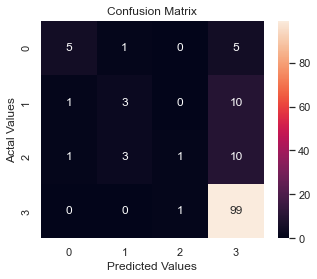

In [422]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [423]:
cm_df

,0,1,2,3
0,5,1,0,5
1,1,3,0,10
2,1,3,1,10
3,0,0,1,99
